## Summary of what we are looking at 
- how we define success. 
- In most cells, give a breif descrition of what we are doing and were files come from.
- have one cell that is markdown, then code cell
- combine cells
- describe visualization. What is the take away, what is the message.
- will have to make some judgement calls on what we could leave out.
- dont need to explain code for vidualization, just what the visualization says.

# How to Get Your Name in Shining Lights
### Alexis Metzler, Benjamin Millunchick, Catherine Grillo

## INTRO!

In [2]:
#importing of all of the things
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1]:
# importing of all the data
# explain where this data came from

streaming = pd.read_csv('MoviesOnStreamingPlatforms_updated.csv').set_index('ID').drop('Unnamed: 0', axis = 1)

imdb = pd.read_csv('imdb.csv')
imdb['date_published'] = pd.to_datetime(imdb['date_published'], errors = 'coerce')


# Alexis' Work
- age group vs imdb rating scatter plot
- genre vs imdb rating set of histograms

### Do movies targeted at different age groups perform differently?
The two things that she made were two ways to look at that

### Do different generas of movies perform differntly?

### Do movies that earn more get better rated?

### Are movies on different streaming platforms get better rated?

### Are movies on steaming platofroms better?

# Ben's Work

### Do better rated movies win more awardsscatterplot compairing imdb ratings and rotton tomatoes

### How has the funding of movies increased over time?

### How have ratings of movies change over time?

### Movies budget vs. rating

# Cat's Work

### Do better rated movies receive more awards/nominations?

We were interested to see if better rated movies by critics and IMDb users will receive more nominations or win more awards. Further, we wanted to compare ratings and winnings across time periods in order to break the data down into more digestable chunks. The time periods we selected are the golden age of Hollywood (1920-1969), the rise of home video (1980-2000), and the last ten years (2010-2020). We felt these time periods were the most notable points in the movie industry.

In [13]:
# the next two lines are reading in the IMDb data, and converting the date_published to datetime
m = pd.read_csv('imdb.csv')
m['date_published'] = pd.to_datetime(m['date_published'], errors = 'coerce')



# function to convert the nan values in the winners column of the oscar data base to be 1 if nominated, and 2 if nominated and won
def nan_fix(df):
    if str(df) == 'nan':
        return 1
    if df == 1.0:
        return 2

# the next four lines of code are reading in the oscar data, then applying a function to change the winners column to numbers that represent whether the movie won or not
a = pd.read_csv('oscars.csv')
a = a[['Winner', 'Film']]
a['Winner'] = a['Winner'].apply(nan_fix)
a = a.rename(columns={"Film": "title"})



# the next two lines create the golden age of film df
m_golden = m[(m['date_published']>'1927-01-01')&(m['date_published']<'1969-12-31')]
m_golden = m_golden[['original_title', 'avg_vote', 'metascore']].rename(columns={'original_title':'title'})

# the next few lines are the golden age of film df merged with oscar data to create a column displaying if a movie has been nominated/won, or not nominated
merge_golden = m_golden.merge(a, how='left', on = 'title')
merge_golden = merge_golden.dropna(subset=['metascore'])
merge_golden['Winner'] = merge_golden['Winner'].fillna(0)

# finding the mean because if it is 0, we know the movie was not nominated,
# if it is 1.0, we know the movie was nominated but did not win,
# and if it is more than 1.0, we know the movie won an award
merge_golden = merge_golden.groupby('title').agg(np.mean)



# the next two lines create the movies during the rise of home video df
m_home = m[(m['date_published']>'1980-01-01')&(m['date_published']<'2000-12-31')]
m_home = m_home[['original_title', 'avg_vote', 'metascore']].rename(columns={'original_title':'title'})

# the next few lines are the rise of home video df merged with oscar data to create a column displaying if a movie has been nominated/won, or not nominated
merge_home = m_home.merge(a, how='left', on = 'title')
merge_home = merge_home.dropna(subset=['metascore'])
merge_home['Winner'] = merge_home['Winner'].fillna(0)

merge_home = merge_home.groupby('title').agg(np.mean)



# movies from the last 10 years
m_now = m[(m['date_published']>'2010-01-01')&(m['date_published']<'2020-12-31')]
m_now = m_now[['original_title', 'avg_vote', 'metascore']].rename(columns={'original_title':'title'})

# the last ten years df merged with oscar data to create column displaying if a movie has been nominated/won
merge_now = m_now.merge(a, how='left', on = 'title')
merge_now = merge_now.dropna(subset=['metascore'])
merge_now['Winner'] = merge_now['Winner'].fillna(0)

merge_now = merge_now.groupby('title').agg(np.mean)

Below is the code block that creates the figure with three scatterplots where the metascore (critic rating) is compared to the user rating and the nominations/winners are highlighted in purple. The green represents the movies that came out during that time period that were not nominated for Oscars. 

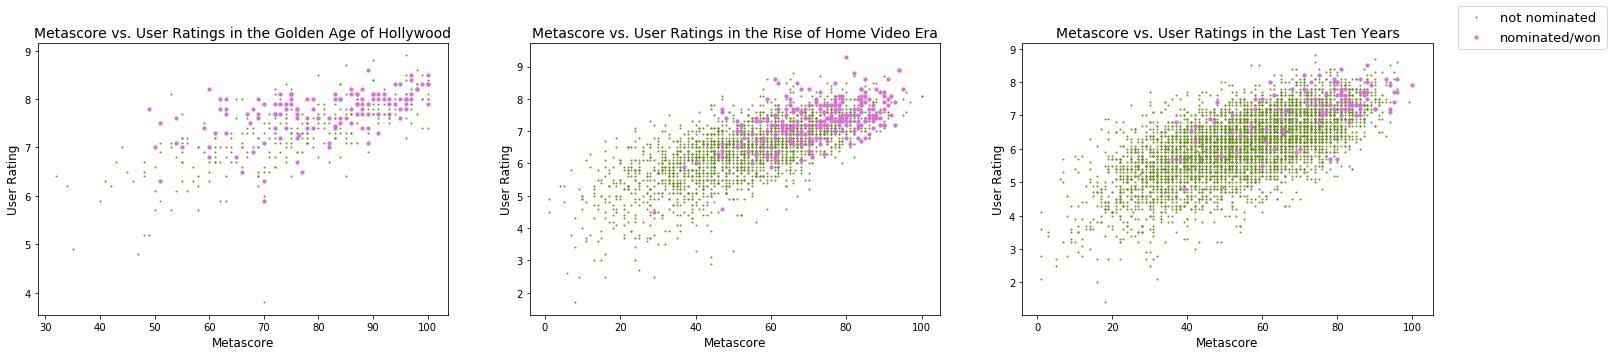

In [14]:
fig_cat, (ax_golden, ax_home, ax_now) = plt.subplots(1,3, figsize=[25,5])

# golden age scatterplot
test_golden = merge_golden
lame_movies_golden = test_golden[test_golden['Winner'] == 0]
good_movies_golden = test_golden[test_golden['Winner'] != 0]
ax_golden.scatter(lame_movies_golden['metascore'], lame_movies_golden['avg_vote'], s=1, color='olivedrab')
ax_golden.scatter(good_movies_golden['metascore'], good_movies_golden['avg_vote'], s=10, color='orchid')
ax_golden.set_title('Metascore vs. User Ratings in the Golden Age of Hollywood', fontsize=14)
ax_golden.set_xlabel('Metascore', fontsize=12)
ax_golden.set_ylabel('User Rating', fontsize=12)

# rise of home videos scatterplot
test_home = merge_home
lame_movies_home = test_home[test_home['Winner'] == 0]
good_movies_home = test_home[test_home['Winner'] != 0]
ax_home.scatter(lame_movies_home['metascore'], lame_movies_home['avg_vote'], s=1, color='olivedrab')
ax_home.scatter(good_movies_home['metascore'], good_movies_home['avg_vote'], s=10, color='orchid')
ax_home.set_title('Metascore vs. User Ratings in the Rise of Home Video Era', fontsize=14)
ax_home.set_xlabel('Metascore', fontsize=12)
ax_home.set_ylabel('User Rating', fontsize=12)

# last 10 years scatterplot
test_now = merge_now
lame_movies_now = test_now[test_now['Winner'] == 0]
good_movies_now = test_now[test_now['Winner'] != 0]
ax_now.scatter(lame_movies_now['metascore'], lame_movies_now['avg_vote'], s=1, color='olivedrab')
ax_now.scatter(good_movies_now['metascore'], good_movies_now['avg_vote'], s=10, color='orchid')
ax_now.set_title('Metascore vs. User Ratings in the Last Ten Years', fontsize=14)
ax_now.set_xlabel('Metascore', fontsize=12)
ax_now.set_ylabel('User Rating', fontsize=12)

fig_cat.legend(['not nominated', 'nominated/won'], loc='upper right', prop={"size":13})

These scatterplots display a general trend that most movies that are nominated and/or win awards are both highly rated by critics (metascore) as well as users of IMDb

## Interesting things to Note - Honorable Mentions

We also had some questions we wanted to use the data to answer that did not relate to movie ratings specifically. The questions we posed are listed and answered below.

### What is the number of movies nominated for Oscars each year?

([<matplotlib.axis.XTick at 0x7fb325286828>,
 <a list of 9 Text xticklabel objects>)

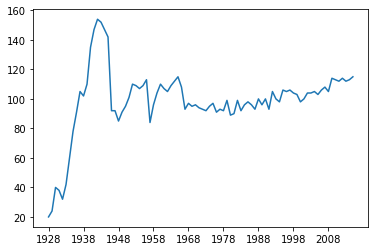

In [15]:
# Read in the Oscar data
award = pd.read_csv('oscars.csv')

# grouping by year and getting the count of unique movies that year
award_grouped = award.groupby('Year').nunique()

# WORK ON THIS!!!!
xaxis = [int(x[-4:]) for x in list(award_grouped.index)]
plt.plot(xaxis, award_grouped['Film'])
plt.xticks(np.arange(min(xaxis), max(xaxis)+1, 10.0))

The chart shows that the number of movies that are nominated each year reached a peak in the 1940s, and has since leveled out. We were hoping to find data that showed that less movies are nominated in recent years, meaning that few movies dominate all the awards. We were surpised to see that this has not been the general trend. While less movies are nominated now than in the mid 1900s, there seems to be a slight increase in nominated movies after 2008, highlighting that more movies are being recognized for their work - which is a good thing.

### How many unique oscar winners are there each year?

We had an interest in seeing if the number of different movies winning oscars has been decreasing. We had a theory that less movies were winning more of the awards in recent years.

([<matplotlib.axis.XTick at 0x7fb33143ec88>,
 <a list of 9 Text xticklabel objects>)

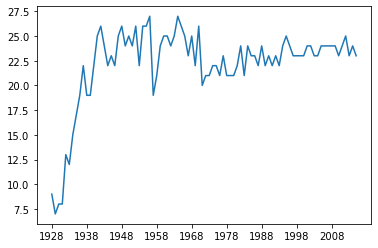

In [16]:
# reading in the Oscar data and grouping by year to get the count of unique movies that year
award2 = award[award['Winner'] == 1].groupby('Year').nunique()

# WORK ON THIS
xaxis2 = [int(x[-4:]) for x in list(award2.index)]
plt.plot(xaxis2, award2['Film'])
plt.xticks(np.arange(min(xaxis2), max(xaxis2)+1, 10.0))

The chart highlights that the number of oscar winners per year has increased since the early 30s (which is expected due to lack of data), and leveled out. 

## What did we learn?